# J0808 GLMs: cyclops Bdata 

In [6]:
import sys
import os
import h5py 

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

if myhost=='hoser':
    sys.path.insert(0, '/Users/dbutts/')
    dirname = os.path.join('.', 'checkpoints')
    datadir = '/Users/dbutts/V1/Conway/'
else:
    #sys.path.insert(0, '/home/dbutts/Code/') 
    datadir = '/home/dbutts/ColorV1/Data/'  
    dirname = '/home/dbutts/ColorV1/CLRworkspace/' # Working directory 

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time
import dill

from NTdatasets.generic import GenericDataset
import NTdatasets.conway.cloud_datasets as datasets

# Utilities
import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.EyeTrackingUtils as ETutils
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
deviceA = torch.device('cuda:0')
device0 = torch.device("cpu")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)
print(device)
%load_ext autoreload
%autoreload 2

Running on Computer: [PFC]


ModuleNotFoundError: No module named 'NDNT'

In [5]:
# Load data (all stim)
fn = 'Jocamo_220808_full_CC_ETCC_nofix_v08'
inclMUs = True
t0 = time()
data = datasets.ColorClouds(
    filenames=[fn], eye_config=3, drift_interval=16, 
    datadir=datadir, luminance_only=True, binocular=False,
    include_MUs=inclMUs)
t1 = time()
print(t1-t0, 'sec elapsed')

NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir+'Jocamo_220808_full_CC_ETCC_nofix_v08_DFextra.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat( datadir+'Jocamo_220808_full_CC_ETCC_nofix_v08_ETupdate.mat')
sac_ts_all = matdat['ALLsac_bins'][0, :]

data.process_fixations( sac_ts_all )
sac_tsB = matdat['sac_binsB'][0, :]
sac_tsL = matdat['sac_binsL'][0, :]
sac_tsR = matdat['sac_binsR'][0, :]

NFIX = torch.max(data.fix_n).detach().numpy() 
print(NFIX, 'fixations')
et1kHzB = matdat['et1kHzB']
et60B = matdat['et60HzB']
et60all = matdat['et60Hz_all']

NameError: name 'time' is not defined

In [4]:
# default stimulus
Reff = torch.mul(data.robs[:, UTunits], data.dfs[:, UTunits]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valET = UTunits[a]
NCv = len(valET)
print("%d out of %d units used"%(len(valET), len(UTunits)))

NameError: name 'data' is not defined

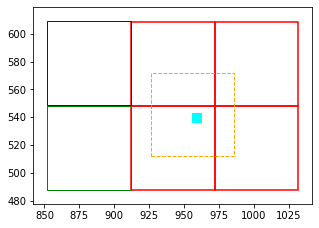

In [116]:
top_corner = np.array([926, 512], dtype=np.int64)
data.draw_stim_locations(top_corner = top_corner, L=60)

In [30]:
data.assemble_stimulus(top_corner=top_corner, fixdot=0, L=60 )

  Writing lam stim 0: overlap 51, 31
  Writing lam stim 1: overlap 51, 29
  Writing lam stim 2: overlap 9, 29
  Writing lam stim 3: overlap 9, 31
  Adding fixation point
  Done


In [31]:
Reff = torch.mul(data.robs[:, valET], data.dfs[:, valET])
nspks = torch.sum(Reff, axis=0)
lag = 4
stas0 = ((data.stim[:-lag, ...].T @ Reff[lag:,:]).squeeze() / nspks).reshape([60,60,-1]).numpy()

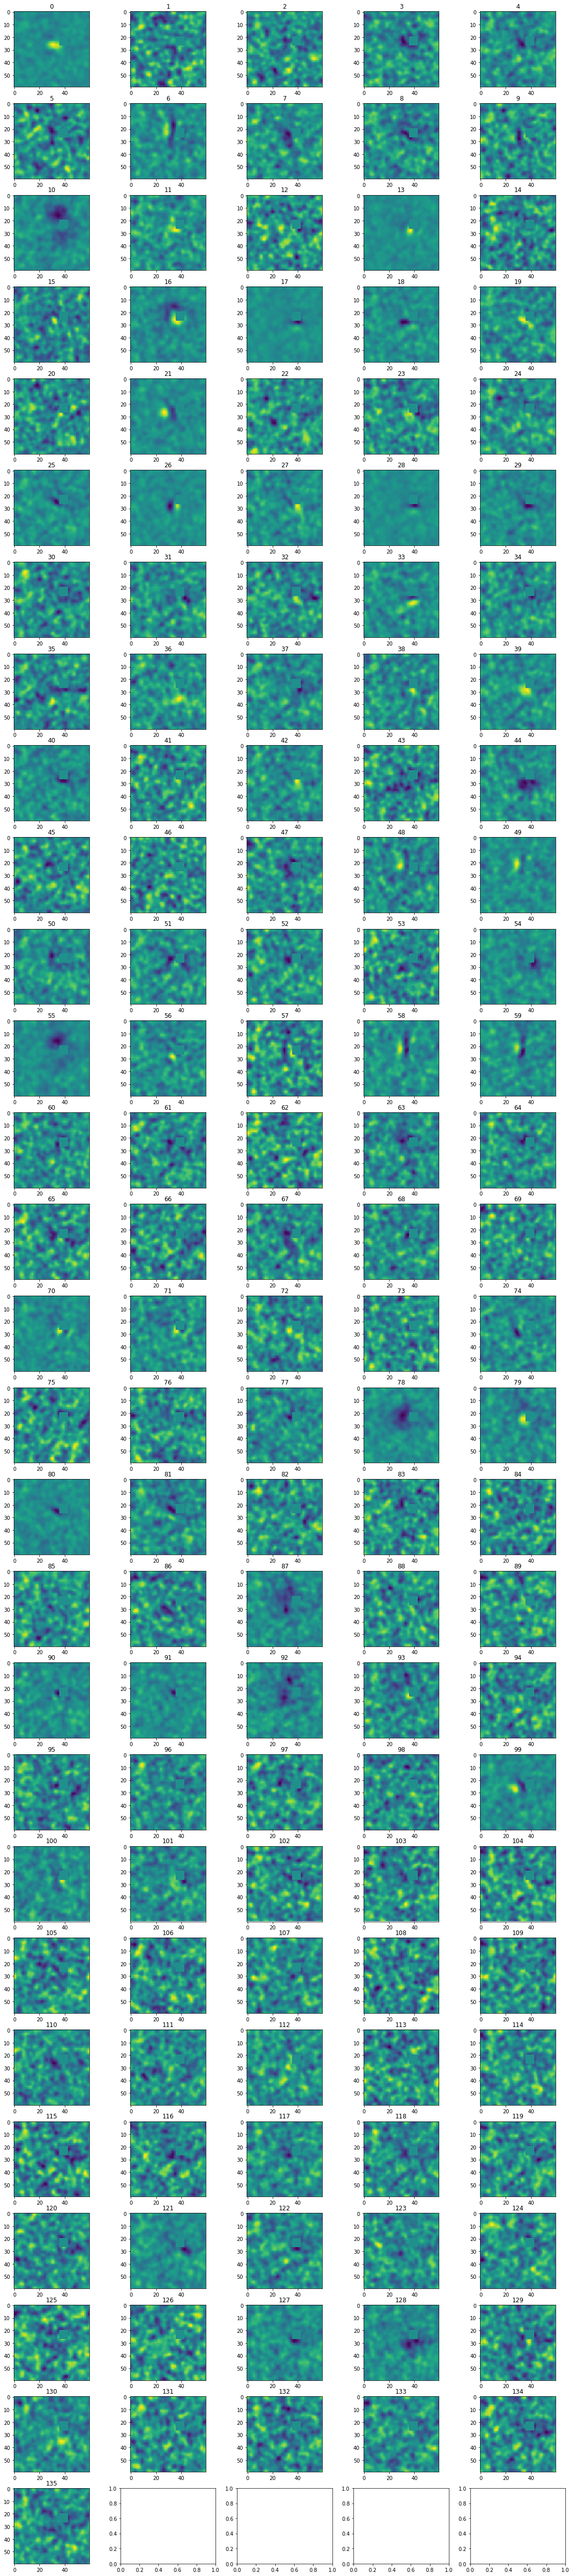

In [32]:
NCv = len(valET)
nrows = int(np.ceil(NCv/5))
ss(nrows,5)
for cc in range(NCv):
    plt.subplot(nrows,5, cc+1)
    imagesc(stas0[:,:, cc])
    plt.title(str(cc))
plt.show()

In [33]:
NXglm = 40
num_lags = 10

LLs0, LLsGLM, XTopt, GLopt = np.zeros([NCv,2]), np.zeros(NCv), np.zeros(NCv), np.zeros(NCv)
glms = [None]*NCv
driftmods = [None]*NCv
Dreg = 0.1

lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    batch_size=16000,
    max_epochs=3,
    max_iter = 200)
#lbfgs_pars['num_workers'] = 0

In [1]:
print(valET)

NameError: name 'valET' is not defined

  Writing lam stim 0: overlap 36, 26
  Writing lam stim 1: overlap 36, 14
  Writing lam stim 2: overlap 4, 14
  Writing lam stim 3: overlap 4, 26
  Adding fixation point
  Time embedding...
  Done
Output set to 1 cells
Cell   0:  R4   LLs = 0.015469789505004883
Cell   0:  R4   LL = 0.01547 -> 0.01669


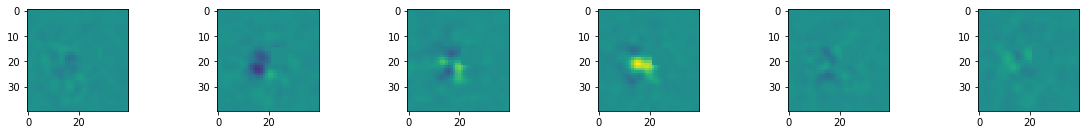

Output set to 1 cells
Cell   1:  R10   LLs = -3.409385681152344e-05
Cell   1:  R5   LL =-0.00003 -> 0.00220


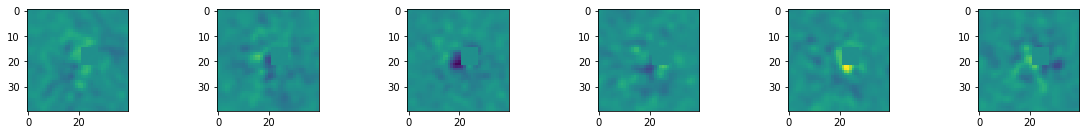

Output set to 1 cells
Cell   2:  R10   LLs = -0.0004088878631591797
Cell   2:  R6   LL =-0.00041 ->-0.00068


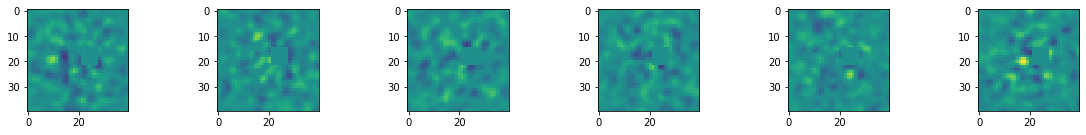

Output set to 1 cells
Cell   3:  R9   LLs = 0.0019452571868896484
Cell   3:  R0   LL = 0.00195 -> 0.00198


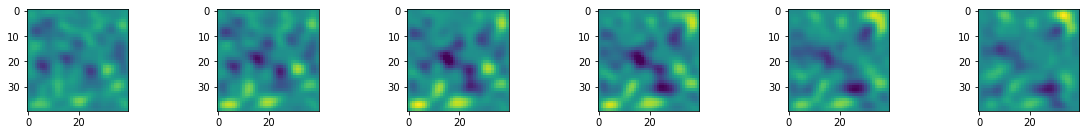

Output set to 1 cells
Cell   4:  R9   LLs = 0.0009143352508544922
Cell   4:  R6   LL = 0.00091 -> 0.00131


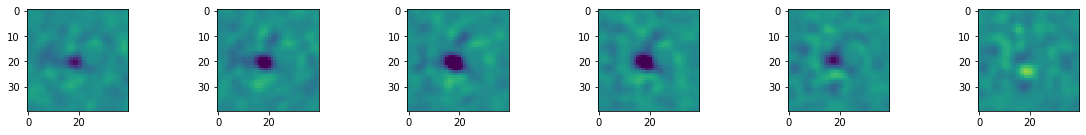

Output set to 1 cells
Cell   5:  R9   LLs = 0.001066446304321289
Cell   5:  R4   LL = 0.00107 -> 0.00116


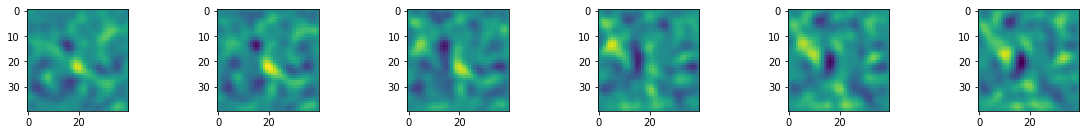

Output set to 1 cells
Cell   6:  R4   LLs = 0.02180624008178711
Cell   6:  R3   LL = 0.02181 -> 0.02156


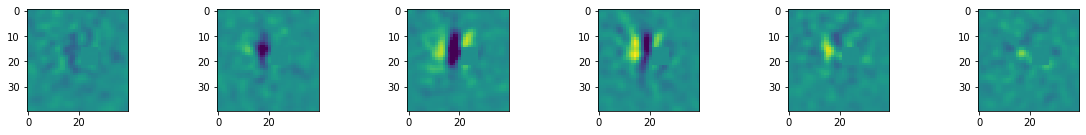

Output set to 1 cells
Cell   7:  R10   LLs = 0.0011048316955566406
Cell   7:  R6   LL = 0.00110 -> 0.00152


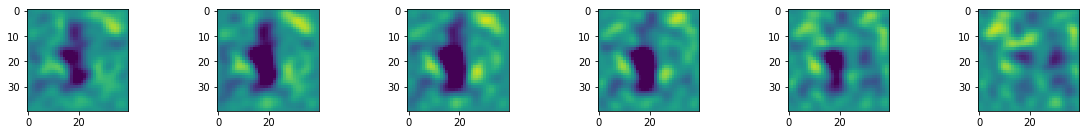

Output set to 1 cells
Cell   8:  R10   LLs = -0.0006859302520751953
Cell   8:  R6   LL =-0.00069 -> 0.00153


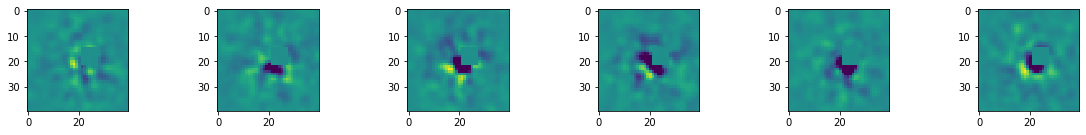

Output set to 1 cells
Cell   9:  R8   LLs = 0.0014526844024658203
Cell   9:  R5   LL = 0.00145 -> 0.00220


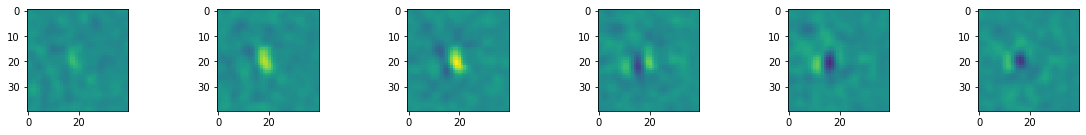

Output set to 1 cells
Cell  10:  R1   LLs = 0.02162480354309082
Cell  10:  R3   LL = 0.02162 -> 0.02127


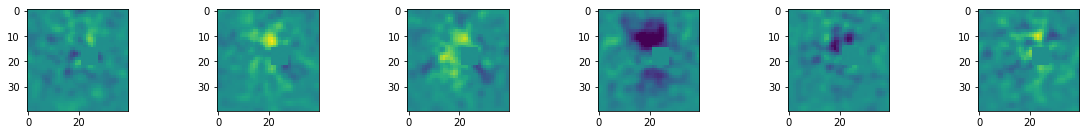

Output set to 1 cells
Cell  11:  R8   LLs = 0.0028388500213623047
Cell  11:  R5   LL = 0.00284 -> 0.00354


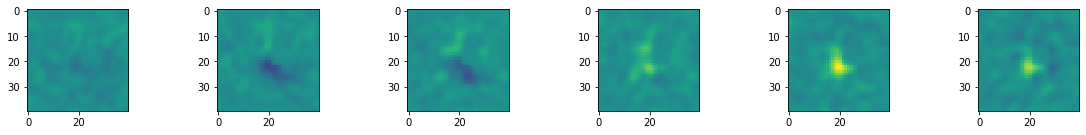

Output set to 1 cells
Cell  12:  R7   LLs = 0.0033452510833740234
Cell  12:  R4   LL = 0.00335 -> 0.00374


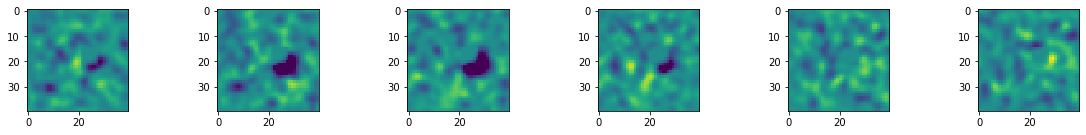

Output set to 1 cells
Cell  13:  R0   LLs = 0.0537714958190918
Cell  13:  R2   LL = 0.05377 -> 0.05277


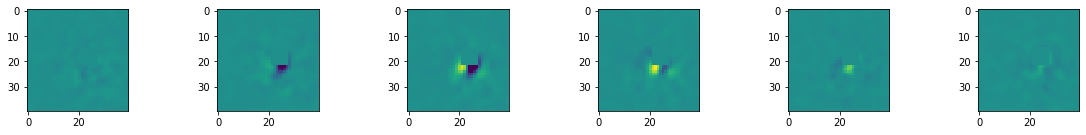

Output set to 1 cells
Cell  14:  R6   LLs = 6.914138793945312e-05
Cell  14:  R5   LL = 0.00007 -> 0.00115


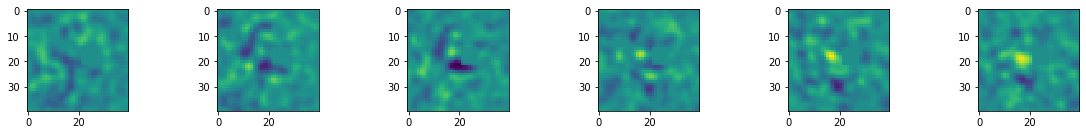

Output set to 1 cells
Cell  15:  R10   LLs = 6.67572021484375e-06
Cell  15:  R6   LL = 0.00001 -> 0.00032


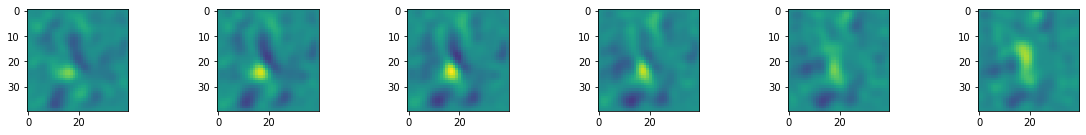

Output set to 1 cells
Cell  16:  R5   LLs = 0.03542947769165039
Cell  16:  R2   LL = 0.03543 -> 0.03643


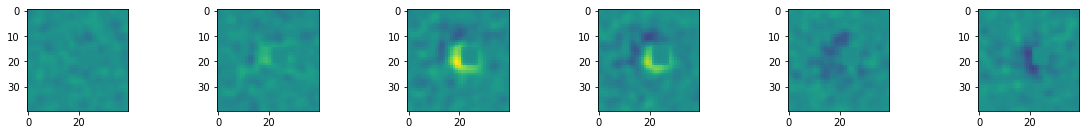

Output set to 1 cells
Cell  17:  R0   LLs = 0.019605398178100586
Cell  17:  R3   LL = 0.01961 -> 0.01998


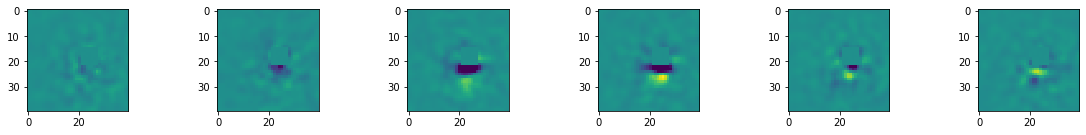

Output set to 1 cells
Cell  18:  R5   LLs = 0.011061310768127441
Cell  18:  R3   LL = 0.01106 -> 0.01122


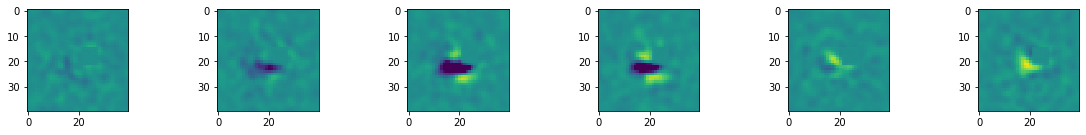

Output set to 1 cells
Cell  19:  R10   LLs = -0.0005326271057128906
Cell  19:  R6   LL =-0.00053 -> 0.00399


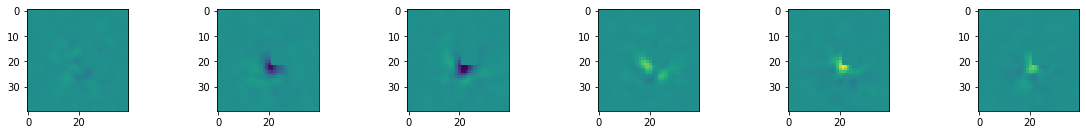

Output set to 1 cells
Cell  20:  R10   LLs = -0.004842042922973633
Cell  20:  R6   LL =-0.00484 ->-0.00002


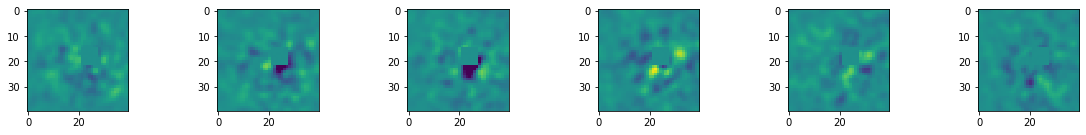

Output set to 1 cells
Cell  21:  R7   LLs = 0.014185428619384766
Cell  21:  R3   LL = 0.01419 -> 0.01448


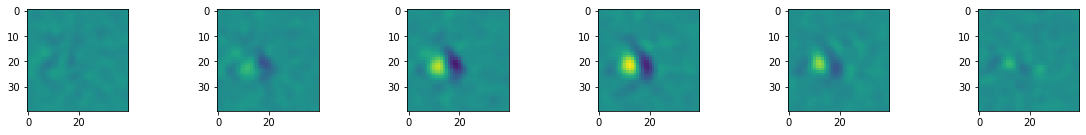

Output set to 1 cells
Cell  22:  R10   LLs = -0.0010187625885009766
Cell  22:  R6   LL =-0.00102 ->-0.00070


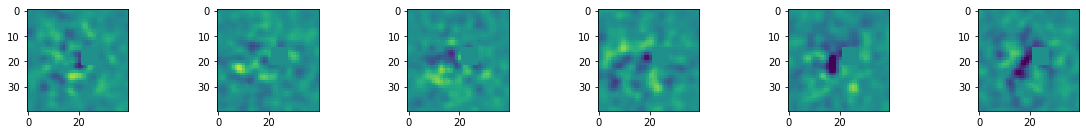

Output set to 1 cells
Cell  23:  R9   LLs = 0.0010046958923339844
Cell  23:  R6   LL = 0.00100 -> 0.00125


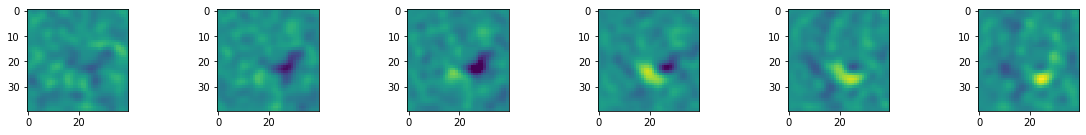

Output set to 1 cells
Cell  24:  R9   LLs = 0.0011944770812988281
Cell  24:  R6   LL = 0.00119 -> 0.00157


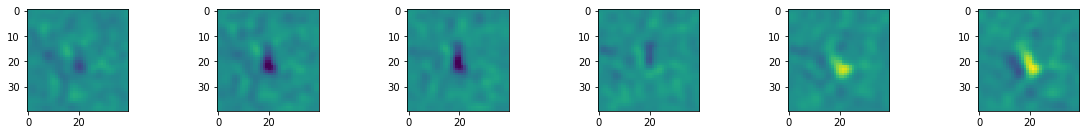

Output set to 1 cells
Cell  25:  R7   LLs = 0.0037352442741394043
Cell  25:  R4   LL = 0.00374 -> 0.00399


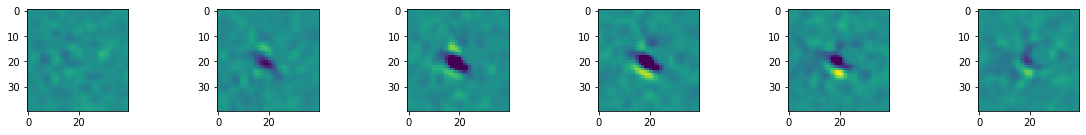

Output set to 1 cells
Cell  26:  R1   LLs = 0.027164697647094727
Cell  26:  R3   LL = 0.02716 -> 0.02722


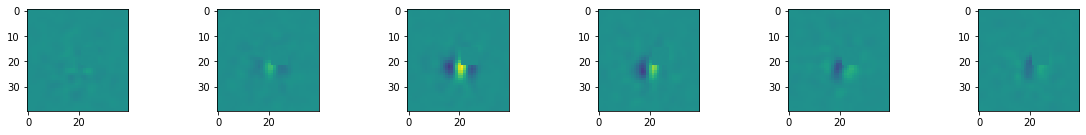

Output set to 1 cells
Cell  27:  R0   LLs = 0.0058547258377075195
Cell  27:  R4   LL = 0.00585 -> 0.00639


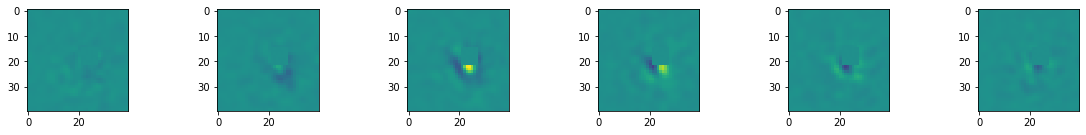

Output set to 1 cells
Cell  28:  R4   LLs = 0.019391775131225586
Cell  28:  R3   LL = 0.01939 -> 0.01969


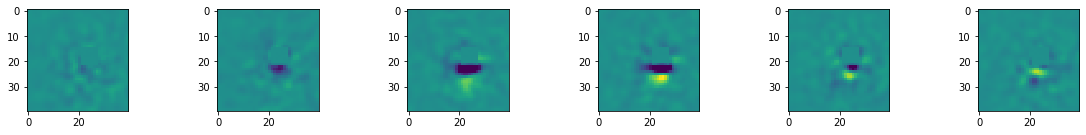

Output set to 1 cells
Cell  29:  R8   LLs = 0.008176565170288086
Cell  29:  R3   LL = 0.00818 -> 0.00840


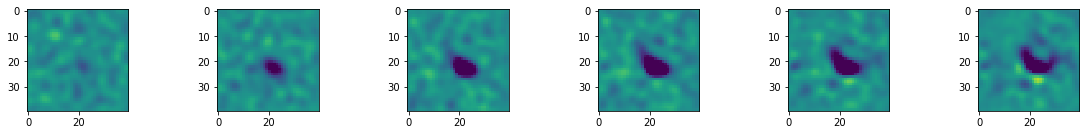

Output set to 1 cells
Cell  30:  R10   LLs = 0.0006961822509765625
Cell  30:  R6   LL = 0.00070 -> 0.00074


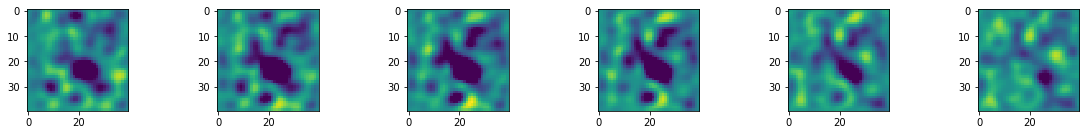

Output set to 1 cells
Cell  31:  R9   LLs = 0.0024275779724121094
Cell  31:  R4   LL = 0.00243 -> 0.00248


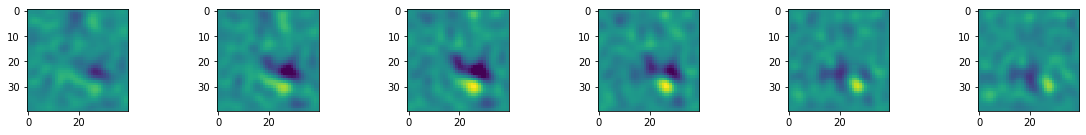

Output set to 1 cells
Cell  32:  R10   LLs = 0.00016355514526367188
Cell  32:  R6   LL = 0.00016 -> 0.00024


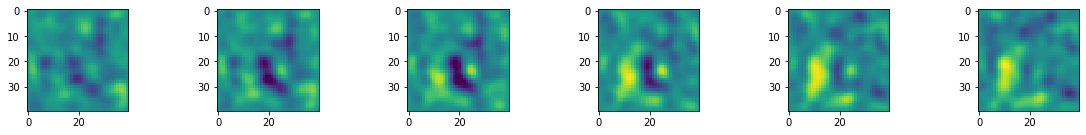

Output set to 1 cells
Cell  33:  R6   LLs = 0.006804943084716797
Cell  33:  R4   LL = 0.00680 -> 0.00735


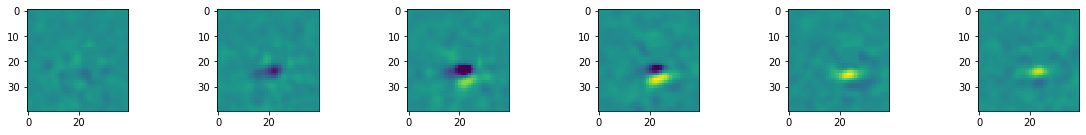

Output set to 1 cells
Cell  34:  R9   LLs = 0.001184225082397461
Cell  34:  R4   LL = 0.00118 -> 0.00130


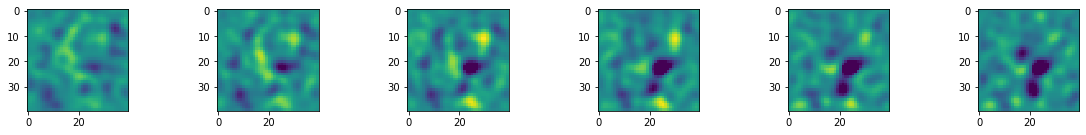

Output set to 1 cells
Cell  35:  R10   LLs = -0.00013399124145507812
Cell  35:  R6   LL =-0.00013 -> 0.00020


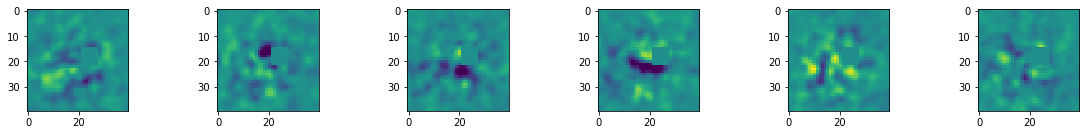

Output set to 1 cells
Cell  36:  R6   LLs = 0.008496761322021484
Cell  36:  R4   LL = 0.00850 -> 0.00935


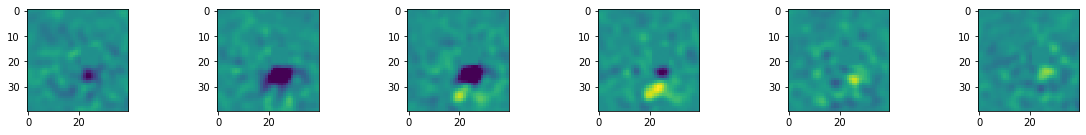

Output set to 1 cells
Cell  37:  R9   LLs = 0.0008985996246337891
Cell  37:  R5   LL = 0.00090 -> 0.00100


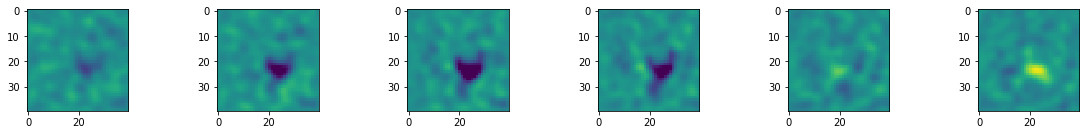

Output set to 1 cells
Cell  38:  R10   LLs = 0.00036907196044921875
Cell  38:  R5   LL = 0.00037 -> 0.00037


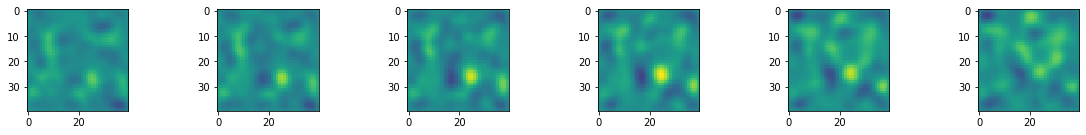

Output set to 1 cells
Cell  39:  R8   LLs = 0.0020262598991394043
Cell  39:  R5   LL = 0.00203 -> 0.00225


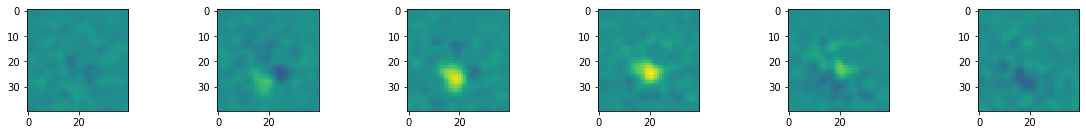

Output set to 1 cells
Cell  40:  R9   LLs = 0.0019135475158691406
Cell  40:  R5   LL = 0.00191 -> 0.00211


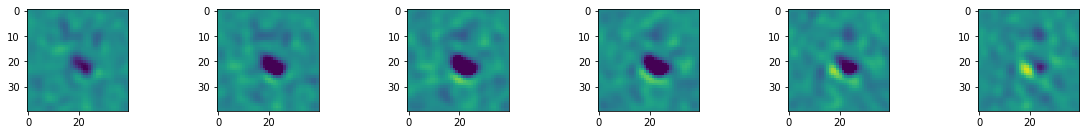

Output set to 1 cells
Cell  41:  R10   LLs = 0.0007448196411132812
Cell  41:  R6   LL = 0.00074 -> 0.00083


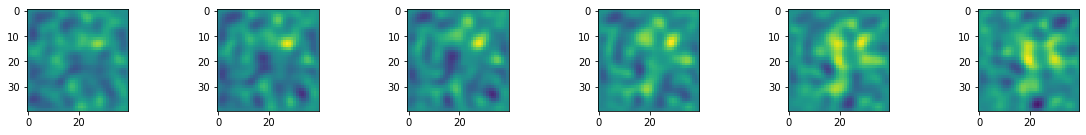

Output set to 1 cells
Cell  42:  R8   LLs = 0.0025403499603271484
Cell  42:  R4   LL = 0.00254 -> 0.00283


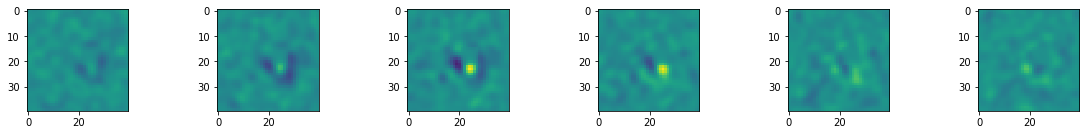

Output set to 1 cells
Cell  43:  R9   LLs = 0.0012447834014892578
Cell  43:  R6   LL = 0.00124 -> 0.00166


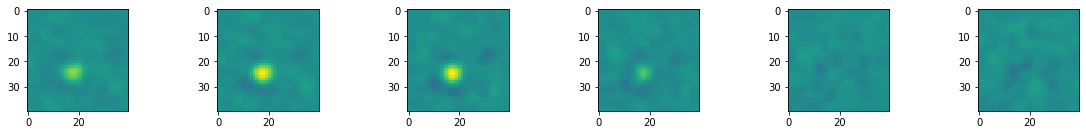

Output set to 1 cells
Cell  44:  R6   LLs = 0.011830568313598633
Cell  44:  R4   LL = 0.01183 -> 0.01239


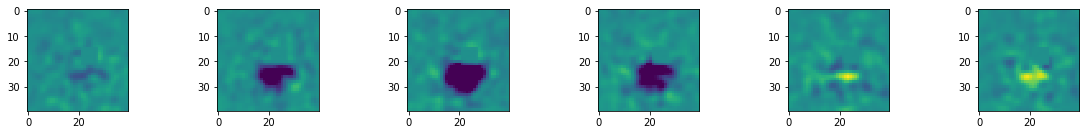

Output set to 1 cells
Cell  45:  R10   LLs = -0.0006201267242431641
Cell  45:  R6   LL =-0.00062 ->-0.00090


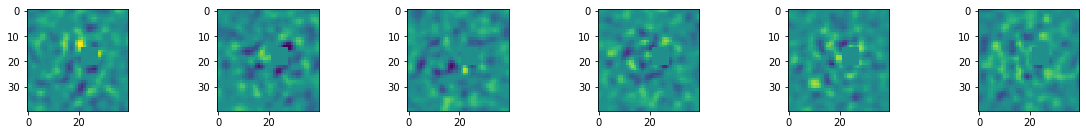

Output set to 1 cells
Cell  46:  R10   LLs = -0.00040435791015625
Cell  46:  R6   LL =-0.00040 ->-0.00147


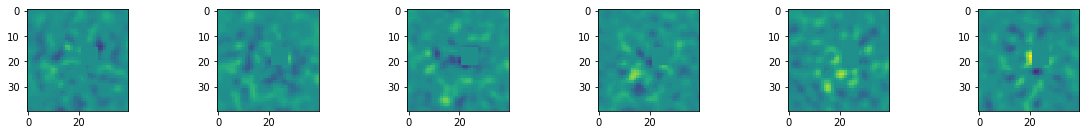

Output set to 1 cells
Cell  47:  R9   LLs = 0.0008265972137451172
Cell  47:  R5   LL = 0.00083 -> 0.00101


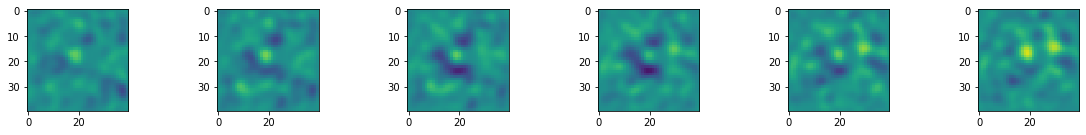

Output set to 1 cells
Cell  48:  R6   LLs = 0.011145353317260742
Cell  48:  R3   LL = 0.01115 -> 0.01094


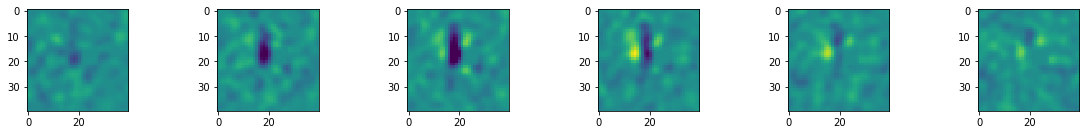

Output set to 1 cells
Cell  49:  R1   LLs = 0.020371437072753906
Cell  49:  R3   LL = 0.02037 -> 0.01988


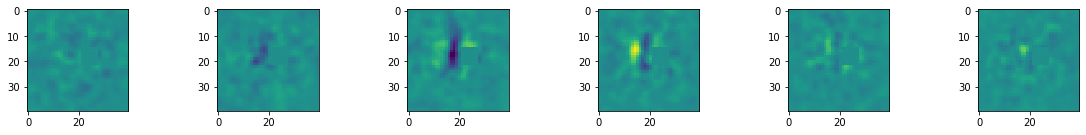

Output set to 1 cells
Cell  50:  R10   LLs = 9.083747863769531e-05
Cell  50:  R6   LL = 0.00009 -> 0.00063


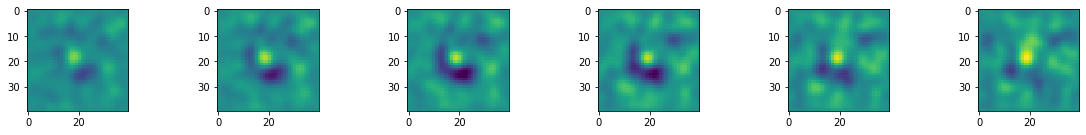

Output set to 1 cells
Cell  51:  R10   LLs = 0.0016574859619140625
Cell  51:  R3   LL = 0.00166 -> 0.00166


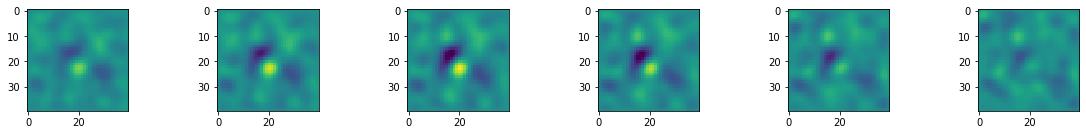

Output set to 1 cells
Cell  52:  R9   LLs = 0.0018017292022705078
Cell  52:  R5   LL = 0.00180 -> 0.00192


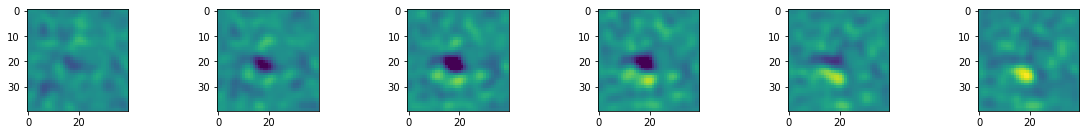

Output set to 1 cells
Cell  53:  R1   LLs = 0.0011358261108398438
Cell  53:  R4   LL = 0.00114 -> 0.00331


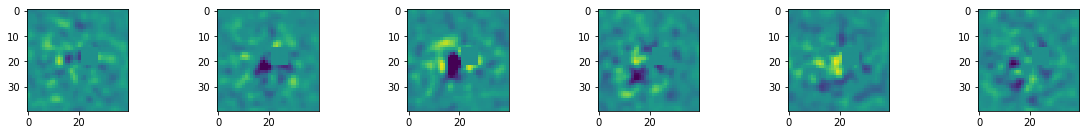

Output set to 1 cells
Cell  54:  R9   LLs = 0.002665996551513672
Cell  54:  R4   LL = 0.00267 -> 0.00272


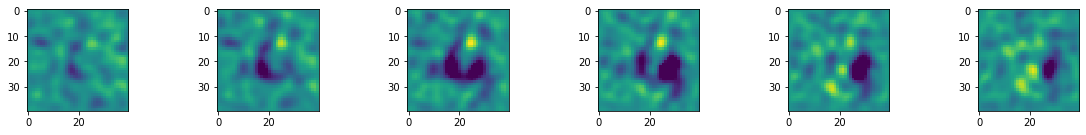

Output set to 1 cells
Cell  55:  R0   LLs = 0.025711536407470703
Cell  55:  R3   LL = 0.02571 -> 0.02585


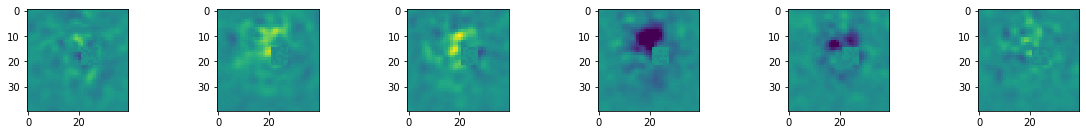

Output set to 1 cells
Cell  56:  R1   LLs = 0.004906415939331055
Cell  56:  R5   LL = 0.00491 -> 0.00715


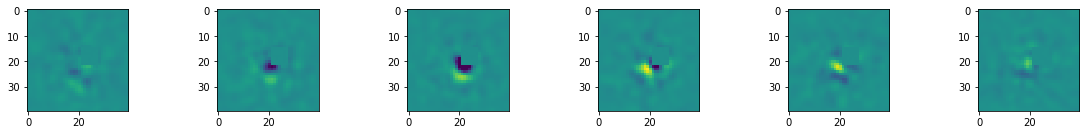

Output set to 1 cells
Cell  57:  R8   LLs = 0.0015783309936523438
Cell  57:  R5   LL = 0.00158 -> 0.00255


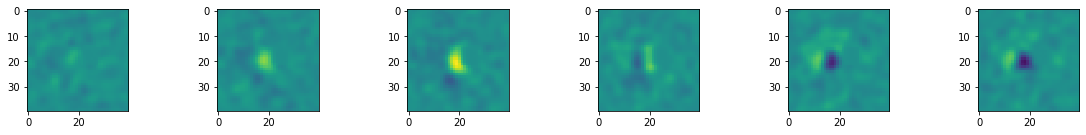

Output set to 1 cells
Cell  58:  R3   LLs = 0.024170637130737305
Cell  58:  R3   LL = 0.02417 -> 0.02416


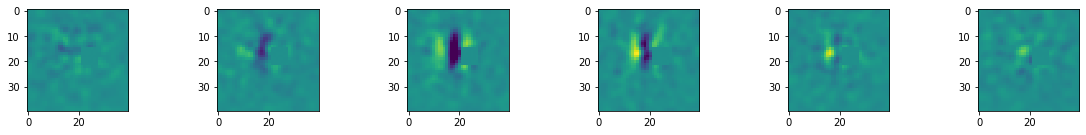

Output set to 1 cells
Cell  59:  R5   LLs = 0.027687549591064453
Cell  59:  R2   LL = 0.02769 -> 0.02714


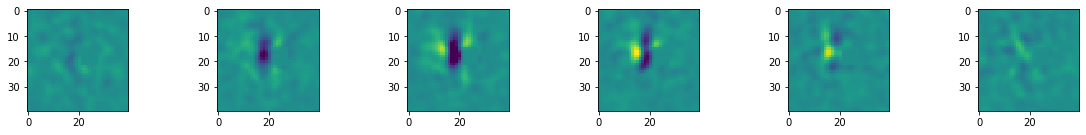

Output set to 1 cells
Cell  60:  R8   LLs = 0.0015139579772949219
Cell  60:  R5   LL = 0.00151 -> 0.00197


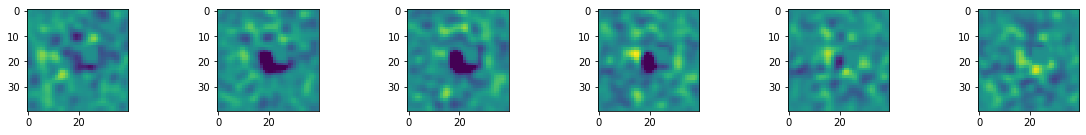

Output set to 1 cells
Cell  61:  R10   LLs = 0.0004062652587890625
Cell  61:  R5   LL = 0.00041 -> 0.00042


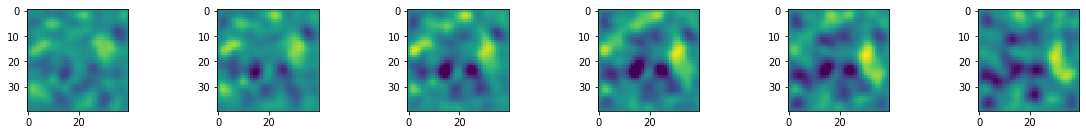

Output set to 1 cells
Cell  62:  R10   LLs = 0.00022602081298828125
Cell  62:  R6   LL = 0.00023 -> 0.00034


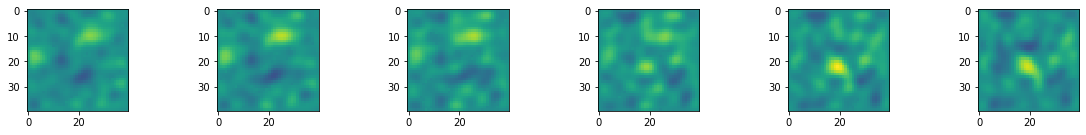

Output set to 1 cells
Cell  63:  R10   LLs = 0.0008566379547119141
Cell  63:  R3   LL = 0.00086 -> 0.00086


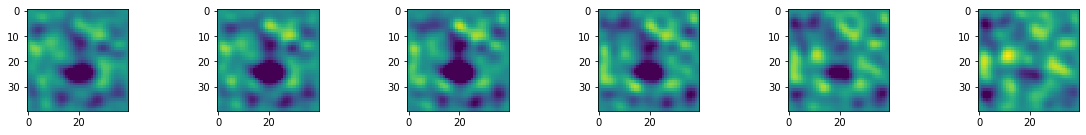

Output set to 1 cells
Cell  64:  R10   LLs = -0.0008466243743896484
Cell  64:  R6   LL =-0.00085 ->-0.00062


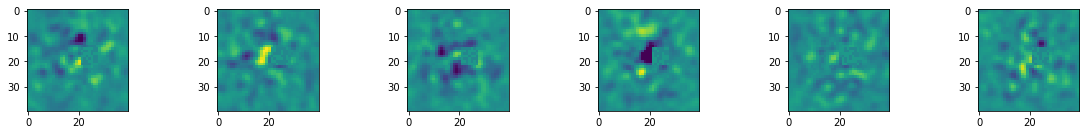

Output set to 1 cells
Cell  65:  R10   LLs = 0.0002435445785522461
Cell  65:  R6   LL = 0.00024 -> 0.00038


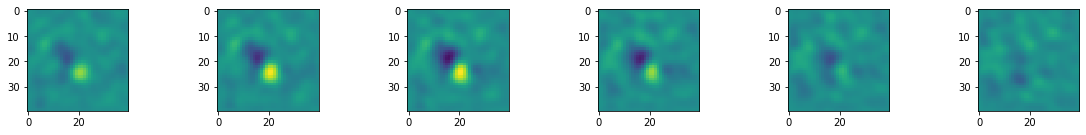

Output set to 1 cells
Cell  66:  R10   LLs = -0.0003223419189453125
Cell  66:  R6   LL =-0.00032 -> 0.00096


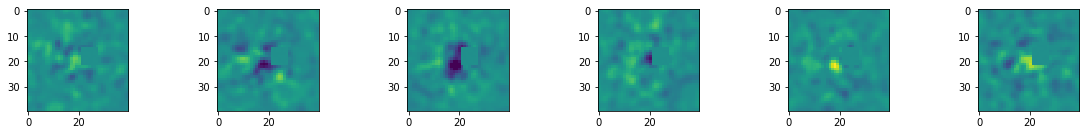

Output set to 1 cells
Cell  67:  R10   LLs = 0.0017974376678466797
Cell  67:  R0   LL = 0.00180 -> 0.00180


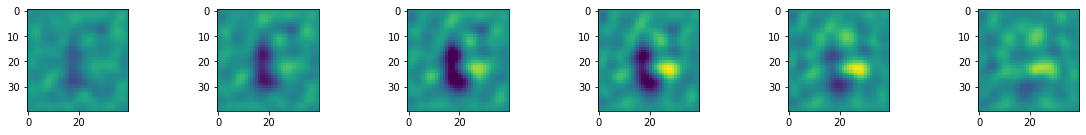

Output set to 1 cells
Cell  68:  R9   LLs = 0.0007941722869873047
Cell  68:  R6   LL = 0.00079 -> 0.00142


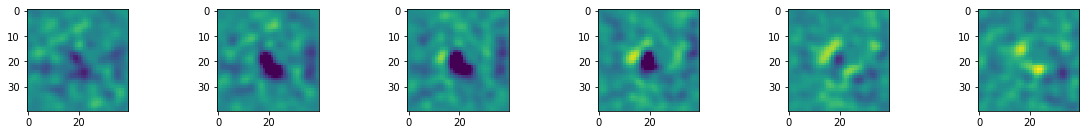

Output set to 1 cells
Cell  69:  R10   LLs = 0.00031113624572753906
Cell  69:  R6   LL = 0.00031 -> 0.00036


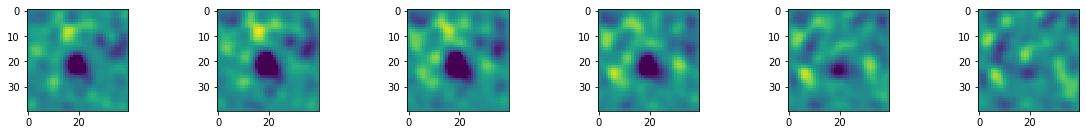

Output set to 1 cells
Cell  70:  R2   LLs = 0.021307945251464844
Cell  70:  R3   LL = 0.02131 -> 0.02202


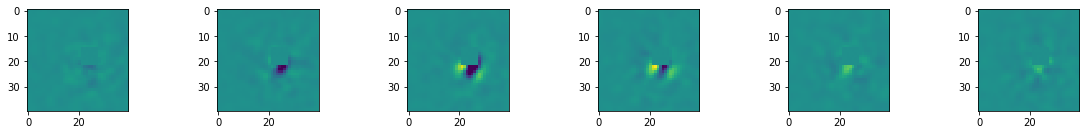

Output set to 1 cells
Cell  71:  R1   LLs = 0.016175031661987305
Cell  71:  R3   LL = 0.01618 -> 0.01652


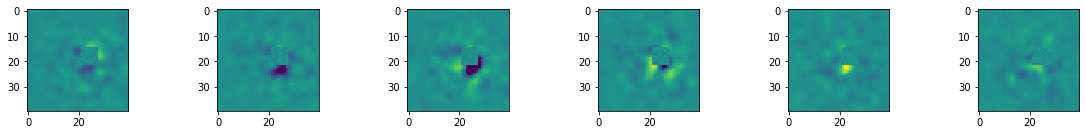

Output set to 1 cells
Cell  72:  R6   LLs = 0.006352901458740234
Cell  72:  R4   LL = 0.00635 -> 0.00708


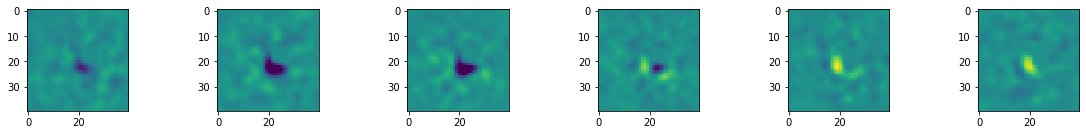

Output set to 1 cells
Cell  73:  R8   LLs = 0.0006167888641357422
Cell  73:  R5   LL = 0.00062 -> 0.00124


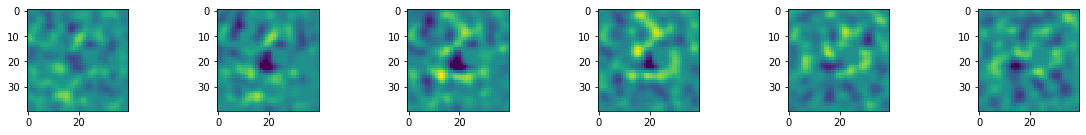

Output set to 1 cells
Cell  74:  R5   LLs = 0.002166748046875
Cell  74:  R5   LL = 0.00217 -> 0.00376


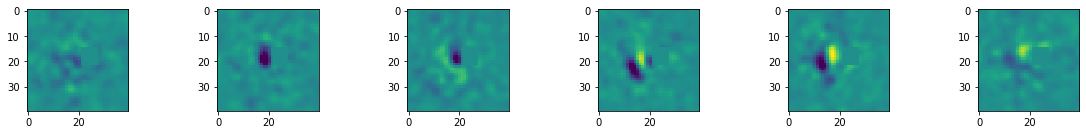

Output set to 1 cells
Cell  75:  R10   LLs = -0.0007777214050292969
Cell  75:  R6   LL =-0.00078 ->-0.00024


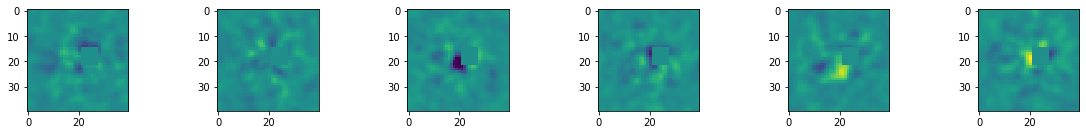

Output set to 1 cells
Cell  76:  R10   LLs = 0.0006797313690185547
Cell  76:  R0   LL = 0.00068 -> 0.00072


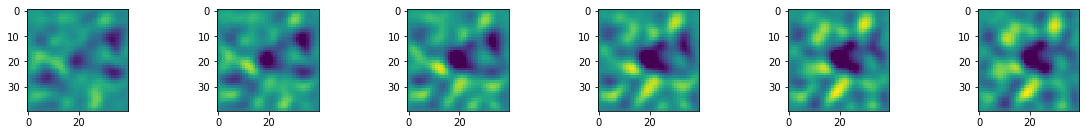

Output set to 1 cells
Cell  77:  R10   LLs = -1.1444091796875e-05
Cell  77:  R6   LL =-0.00001 -> 0.00136


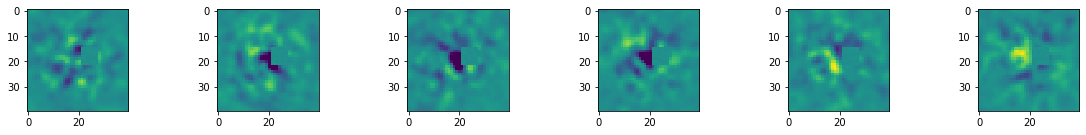

Output set to 1 cells
Cell  78:  R2   LLs = 0.08049607276916504
Cell  78:  R2   LL = 0.08050 -> 0.08103


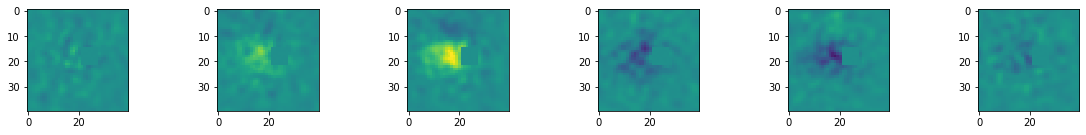

Output set to 1 cells
Cell  79:  R5   LLs = 0.014234066009521484
Cell  79:  R3   LL = 0.01423 -> 0.01482


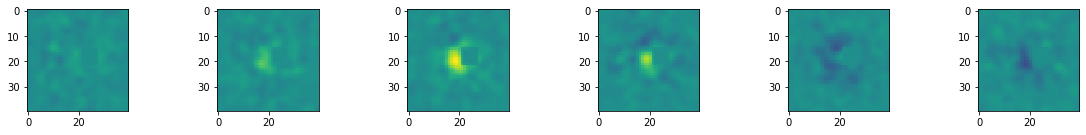

Output set to 1 cells
Cell  80:  R9   LLs = 0.005852222442626953
Cell  80:  R4   LL = 0.00585 -> 0.00623


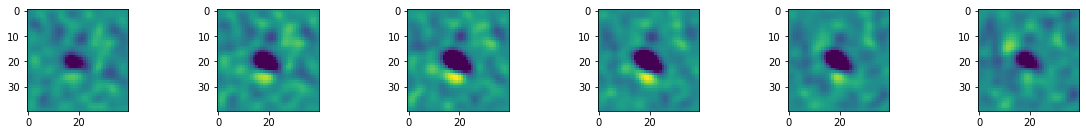

Output set to 1 cells
Cell  81:  R9   LLs = 0.0010213851928710938
Cell  81:  R6   LL = 0.00102 -> 0.00149


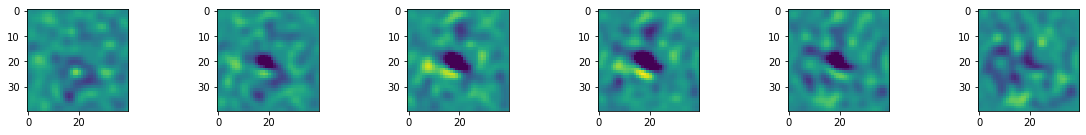

Output set to 1 cells
Cell  82:  R9   LLs = 0.0008072853088378906
Cell  82:  R5   LL = 0.00081 -> 0.00097


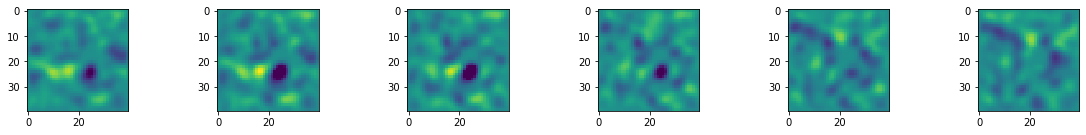

Output set to 1 cells
Cell  83:  R10   LLs = 0.0008876323699951172
Cell  83:  R4   LL = 0.00089 -> 0.00092


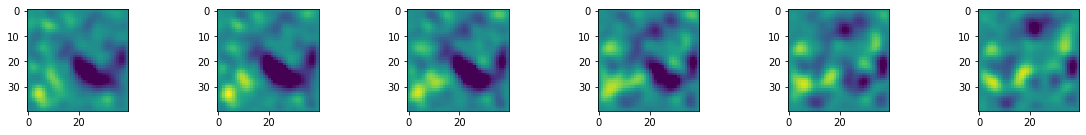

Output set to 1 cells
Cell  84:  R10   LLs = -0.0003485679626464844
Cell  84:  R6   LL =-0.00035 -> 0.00022


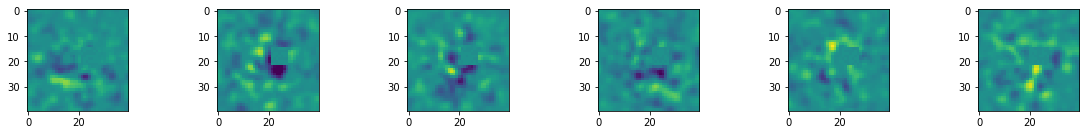

Output set to 1 cells
Cell  85:  R10   LLs = 0.0001201629638671875
Cell  85:  R6   LL = 0.00012 -> 0.00014


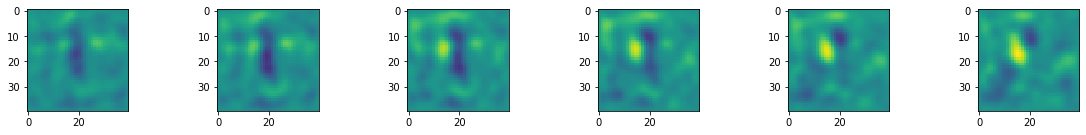

Output set to 1 cells
Cell  86:  R10   LLs = 0.0002601146697998047
Cell  86:  R6   LL = 0.00026 -> 0.00037


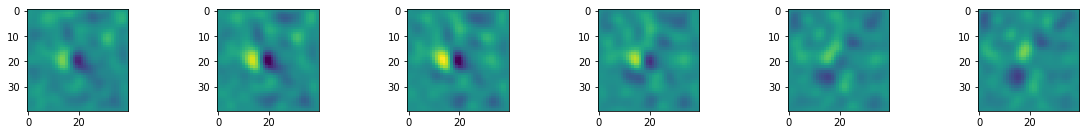

Output set to 1 cells
Cell  87:  R4   LLs = 0.039231061935424805
Cell  87:  R3   LL = 0.03923 -> 0.03868


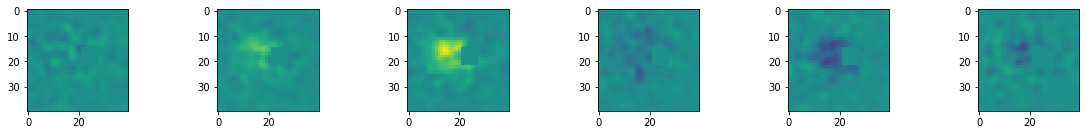

Output set to 1 cells
Cell  88:  R6   LLs = 0.00552821159362793
Cell  88:  R4   LL = 0.00553 -> 0.00613


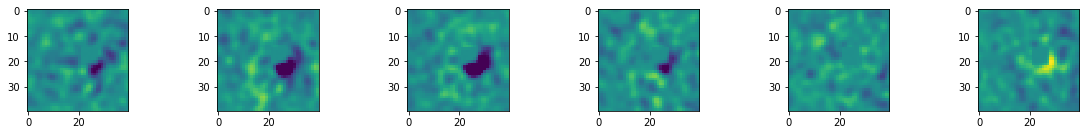

Output set to 1 cells
Cell  89:  R9   LLs = 0.001169443130493164
Cell  89:  R5   LL = 0.00117 -> 0.00146


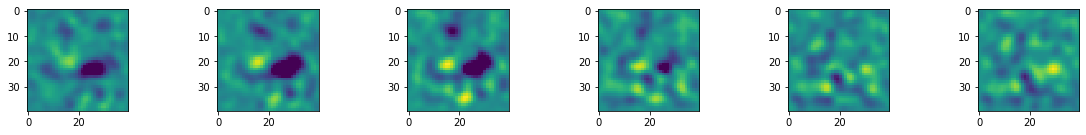

Output set to 1 cells
Cell  90:  R9   LLs = 0.0007648468017578125
Cell  90:  R6   LL = 0.00076 -> 0.00169


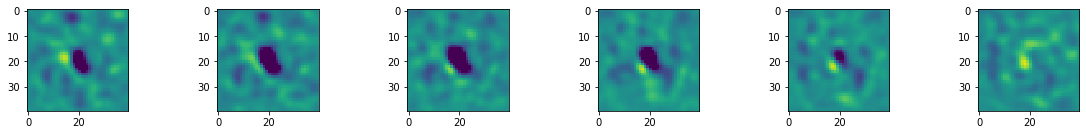

Output set to 1 cells
Cell  91:  R8   LLs = 0.0031211376190185547
Cell  91:  R5   LL = 0.00312 -> 0.00420


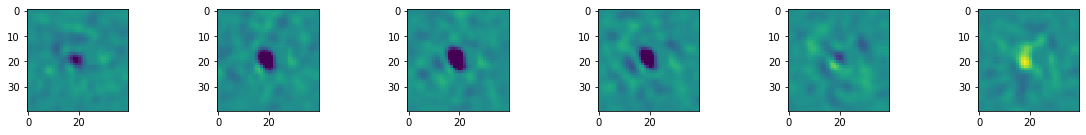

Output set to 1 cells
Cell  92:  R2   LLs = 0.03252553939819336
Cell  92:  R3   LL = 0.03253 -> 0.03220


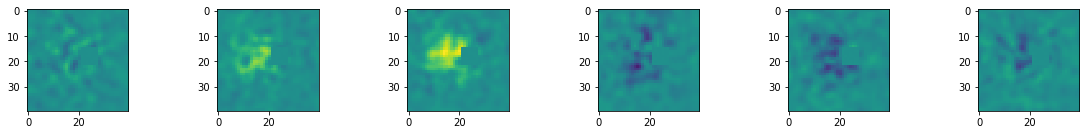

Output set to 1 cells
Cell  93:  R7   LLs = 0.003093242645263672
Cell  93:  R4   LL = 0.00309 -> 0.00407


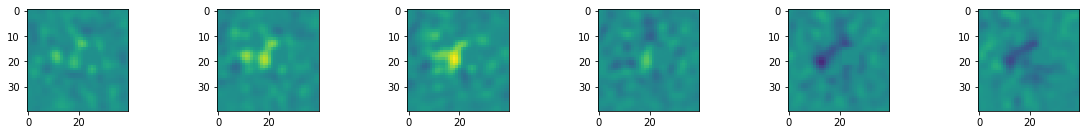

Output set to 1 cells
Cell  94:  R10   LLs = -0.00022721290588378906
Cell  94:  R6   LL =-0.00023 -> 0.00153


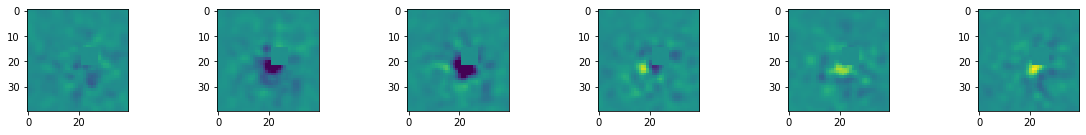

Output set to 1 cells
Cell  95:  R10   LLs = 0.0002880096435546875
Cell  95:  R6   LL = 0.00029 -> 0.00036


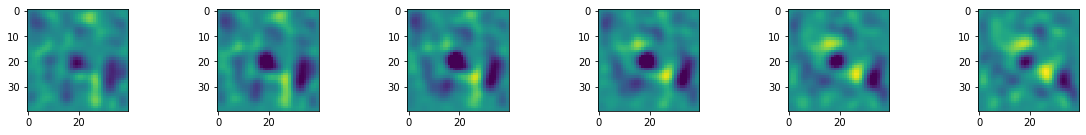

Output set to 1 cells
Cell  96:  R9   LLs = 0.001026153564453125
Cell  96:  R4   LL = 0.00103 -> 0.00118


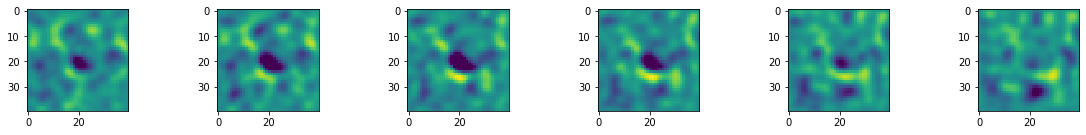

Output set to 1 cells
Cell  97:  R5   LLs = 0.005152463912963867
Cell  97:  R3   LL = 0.00515 -> 0.00527


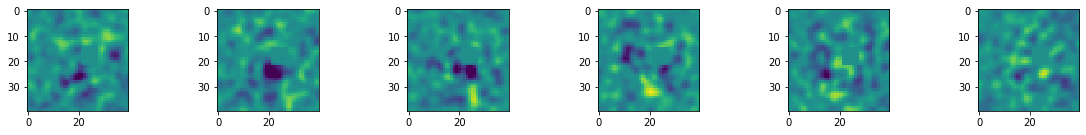

Output set to 1 cells
Cell  98:  R10   LLs = -0.00031566619873046875
Cell  98:  R6   LL =-0.00032 ->-0.00108


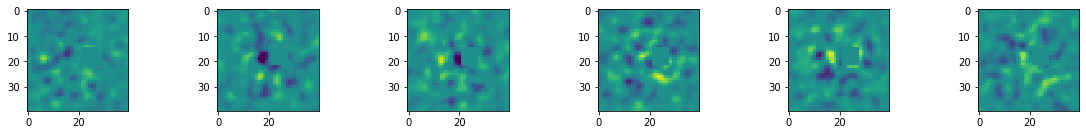

Output set to 1 cells
Cell  99:  R8   LLs = 0.007368803024291992
Cell  99:  R4   LL = 0.00737 -> 0.00766


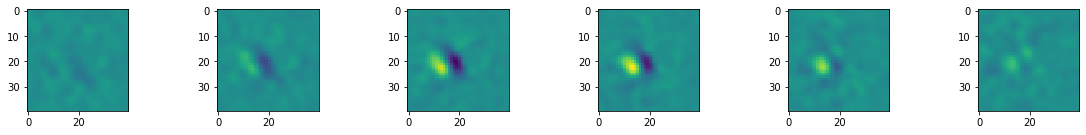

Output set to 1 cells
Cell 100:  R9   LLs = 0.0030922889709472656
Cell 100:  R1   LL = 0.00309 -> 0.00314


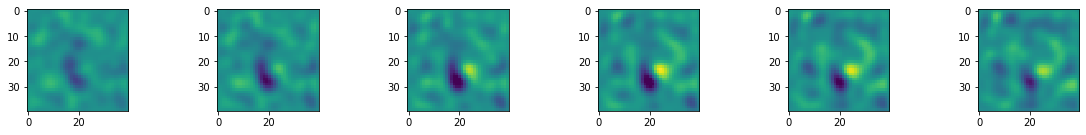

Output set to 1 cells
Cell 101:  R9   LLs = 0.0010101795196533203
Cell 101:  R5   LL = 0.00101 -> 0.00123


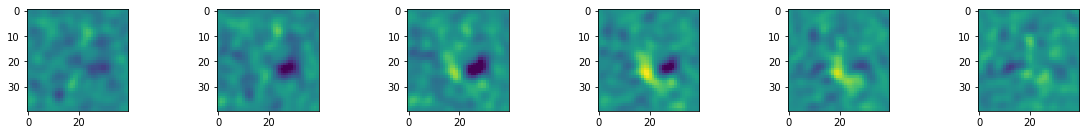

Output set to 1 cells
Cell 102:  R10   LLs = -0.00041937828063964844
Cell 102:  R6   LL =-0.00042 -> 0.00002


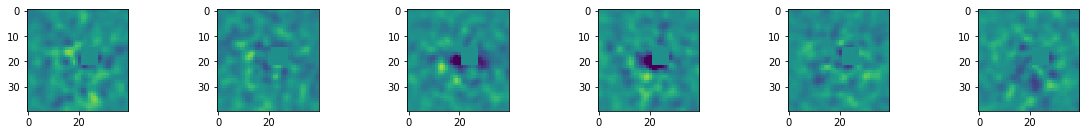

Output set to 1 cells
Cell 103:  R10   LLs = -0.0008971691131591797
Cell 103:  R6   LL =-0.00090 ->-0.00050


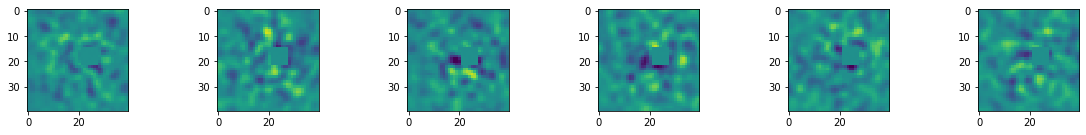

Output set to 1 cells
Cell 104:  R9   LLs = 0.0026445388793945312
Cell 104:  R5   LL = 0.00264 -> 0.00282


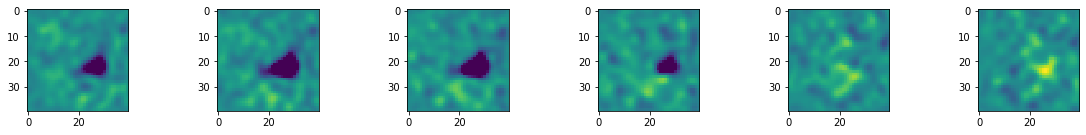

Output set to 1 cells
Cell 105:  R10   LLs = 0.00023698806762695312
Cell 105:  R6   LL = 0.00024 -> 0.00052


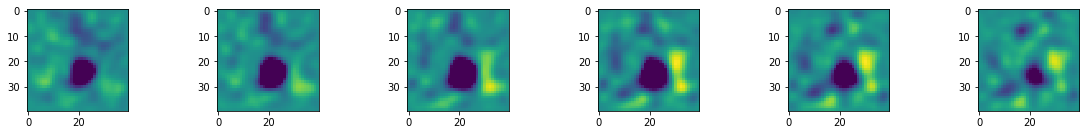

Output set to 1 cells
Cell 106:  R8   LLs = 0.0015192031860351562
Cell 106:  R4   LL = 0.00152 -> 0.00169


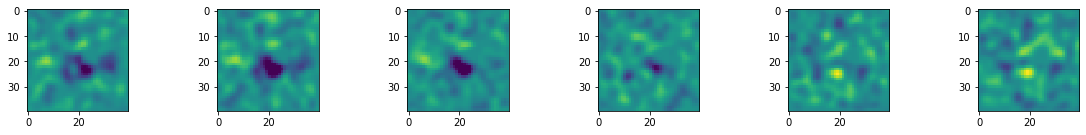

Output set to 1 cells
Cell 107:  R10   LLs = -0.0008230209350585938
Cell 107:  R6   LL =-0.00082 ->-0.00030


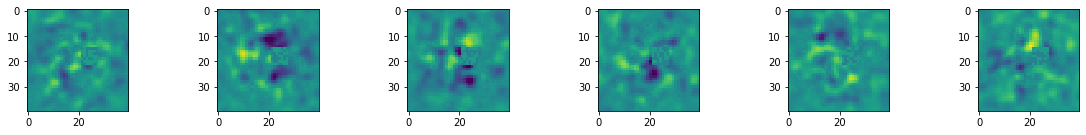

Output set to 1 cells
Cell 108:  R6   LLs = 0.0036325454711914062
Cell 108:  R4   LL = 0.00363 -> 0.00420


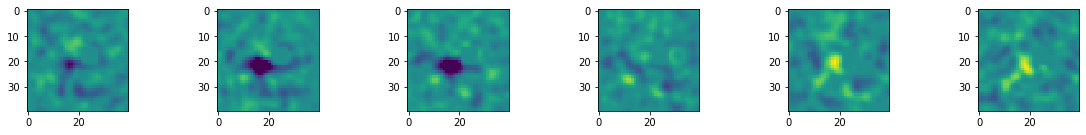

Output set to 1 cells
Cell 109:  R5   LLs = 0.005715370178222656
Cell 109:  R5   LL = 0.00572 -> 0.00833


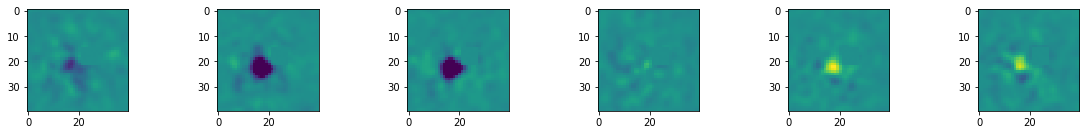

Output set to 1 cells
Cell 110:  R10   LLs = 0.00017547607421875
Cell 110:  R6   LL = 0.00018 -> 0.00028


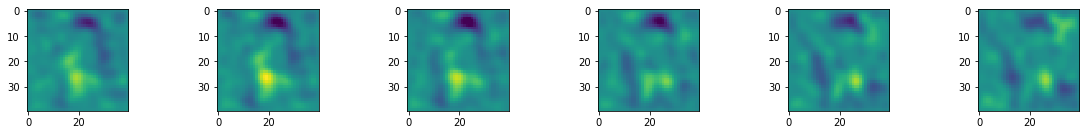

Output set to 1 cells
Cell 111:  R8   LLs = 0.0028891563415527344
Cell 111:  R4   LL = 0.00289 -> 0.00300


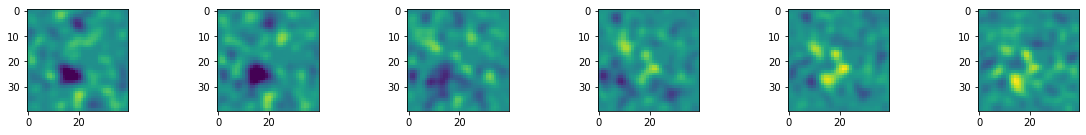

Output set to 1 cells
Cell 112:  R10   LLs = -0.00019621849060058594
Cell 112:  R6   LL =-0.00020 -> 0.00032


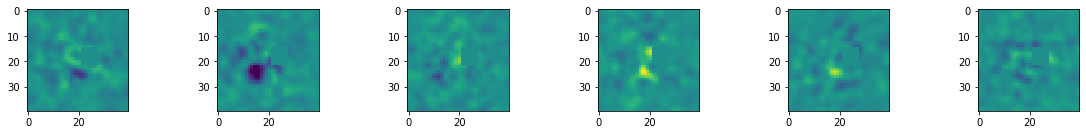

Output set to 1 cells
Cell 113:  R10   LLs = 0.00024580955505371094
Cell 113:  R6   LL = 0.00025 -> 0.00035


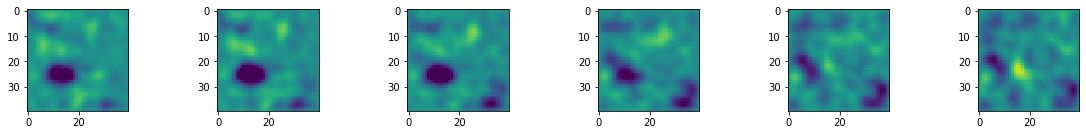

Output set to 1 cells
Cell 114:  R9   LLs = 0.0023941993713378906
Cell 114:  R5   LL = 0.00239 -> 0.00251


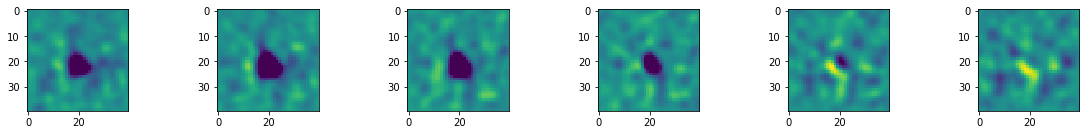

Output set to 1 cells
Cell 115:  R8   LLs = 0.0031707286834716797
Cell 115:  R5   LL = 0.00317 -> 0.00349


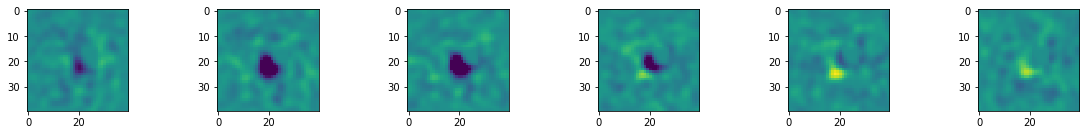

Output set to 1 cells
Cell 116:  R7   LLs = 0.002751588821411133
Cell 116:  R3   LL = 0.00275 -> 0.00298


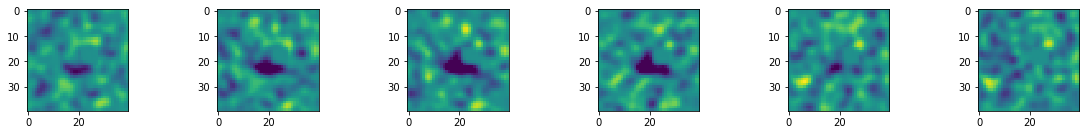

Output set to 1 cells
Cell 117:  R10   LLs = 6.341934204101562e-05
Cell 117:  R6   LL = 0.00006 -> 0.00018


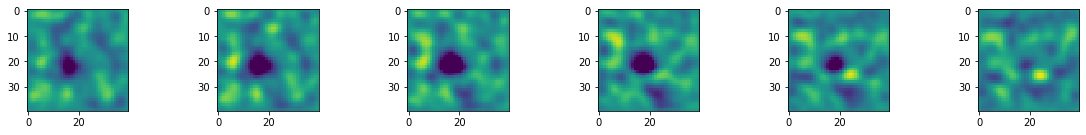

Output set to 1 cells
Cell 118:  R10   LLs = 0.000202178955078125
Cell 118:  R6   LL = 0.00020 -> 0.00035


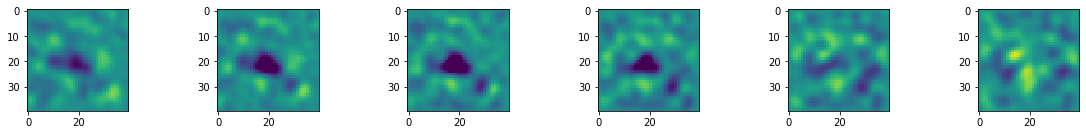

Output set to 1 cells
Cell 119:  R10   LLs = 0.00011301040649414062
Cell 119:  R6   LL = 0.00011 -> 0.00017


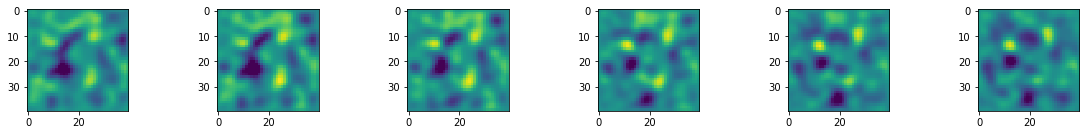

Output set to 1 cells
Cell 120:  R10   LLs = -0.0007855892181396484
Cell 120:  R6   LL =-0.00079 ->-0.00023


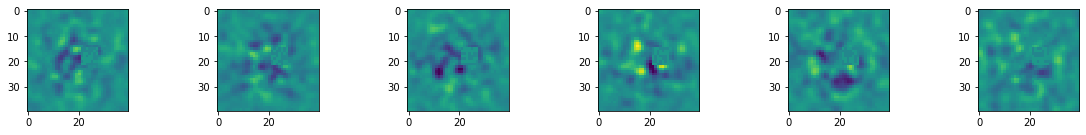

Output set to 1 cells
Cell 121:  R7   LLs = 0.002013683319091797
Cell 121:  R6   LL = 0.00201 -> 0.00339


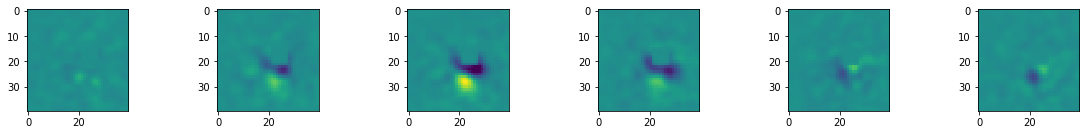

Output set to 1 cells
Cell 122:  R9   LLs = 0.0004220008850097656
Cell 122:  R6   LL = 0.00042 -> 0.00103


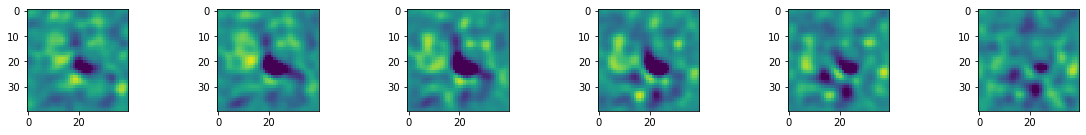

Output set to 1 cells
Cell 123:  R10   LLs = 0.0006842613220214844
Cell 123:  R6   LL = 0.00068 -> 0.00078


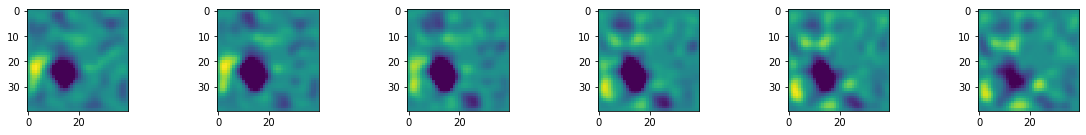

Output set to 1 cells
Cell 124:  R8   LLs = 0.0054264068603515625
Cell 124:  R2   LL = 0.00543 -> 0.00550


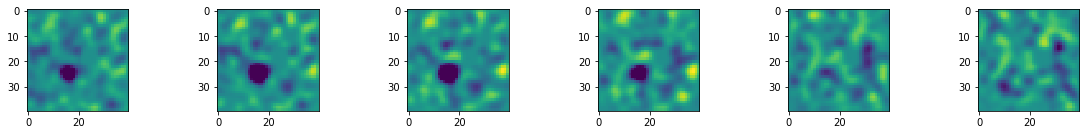

Output set to 1 cells
Cell 125:  R10   LLs = -0.0004856586456298828
Cell 125:  R6   LL =-0.00049 ->-0.00034


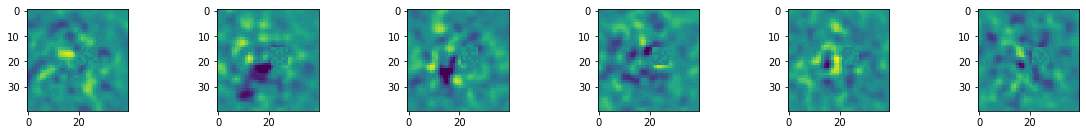

Output set to 1 cells
Cell 126:  R5   LLs = 0.009053230285644531
Cell 126:  R3   LL = 0.00905 -> 0.00889


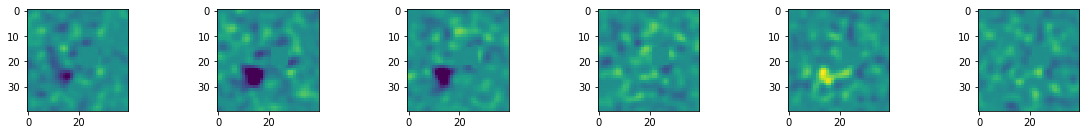

Output set to 1 cells
Cell 127:  R8   LLs = 0.0025420188903808594
Cell 127:  R6   LL = 0.00254 -> 0.00338


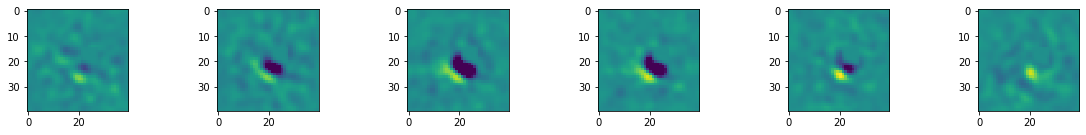

Output set to 1 cells
Cell 128:  R8   LLs = 0.012076616287231445
Cell 128:  R3   LL = 0.01208 -> 0.01225


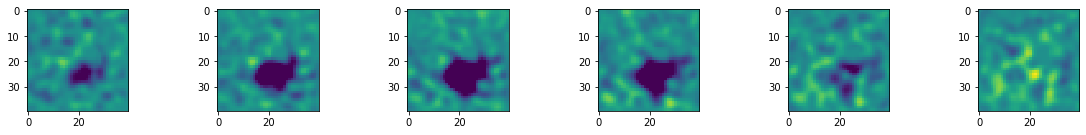

Output set to 1 cells
Cell 129:  R10   LLs = 0.0002391338348388672
Cell 129:  R6   LL = 0.00024 -> 0.00040


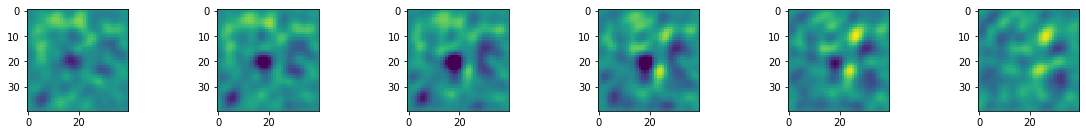

Output set to 1 cells
Cell 130:  R7   LLs = 0.00456690788269043
Cell 130:  R5   LL = 0.00457 -> 0.00650


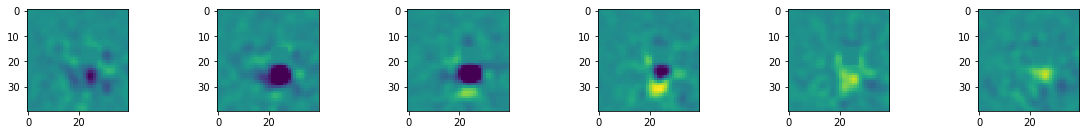

Output set to 1 cells
Cell 131:  R9   LLs = 0.0013415813446044922
Cell 131:  R6   LL = 0.00134 -> 0.00162


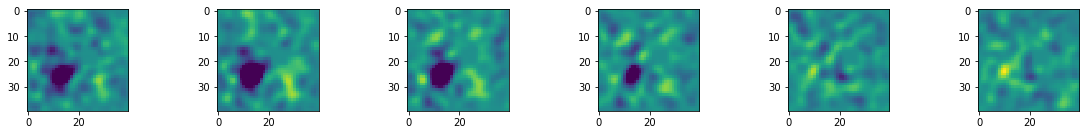

Output set to 1 cells
Cell 132:  R10   LLs = 0.00030422210693359375
Cell 132:  R6   LL = 0.00030 -> 0.00047


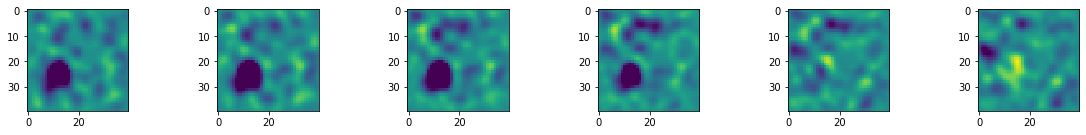

Output set to 1 cells
Cell 133:  R9   LLs = 0.0010805130004882812
Cell 133:  R6   LL = 0.00108 -> 0.00154


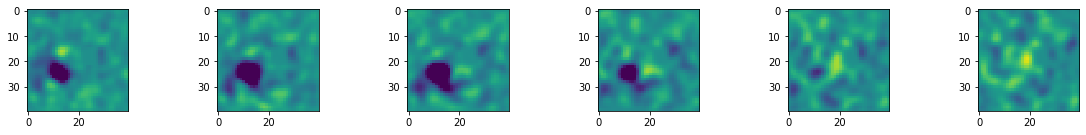

Output set to 1 cells
Cell 134:  R10   LLs = -0.00028312206268310547
Cell 134:  R6   LL =-0.00028 ->-0.00041


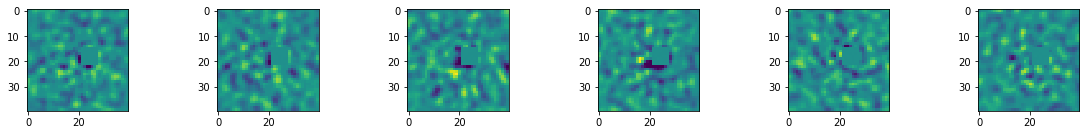

Output set to 1 cells
Cell 135:  R8   LLs = 0.0019545555114746094
Cell 135:  R5   LL = 0.00195 -> 0.00246


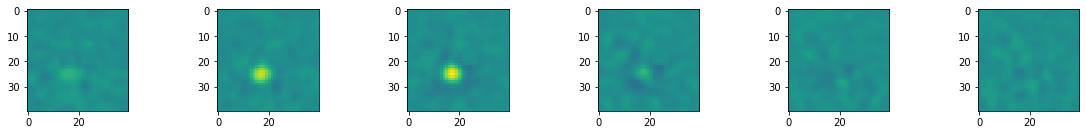

In [117]:
tc40 = [top_corner[0]+10, top_corner[1]+10]

XTreg = 20
L1reg = 0.5
GLreg = 4.0

glm_layer = NDNLayer.layer_dict( 
    input_dims=[1, NXglm, NXglm, num_lags], num_filters=1, bias=False, NLtype='lin', initialize_center=True)
glm_layer['reg_vals'] = {'d2xt': XTreg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':100} 

stim_net =  FFnetwork.ffnet_dict( xstim_n='stim', layer_list=[glm_layer] )

drift_pars1 = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
drift_pars1['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0} } 

# for stand-alone drift model
drift_pars1N = deepcopy(drift_pars1)
drift_pars1N['NLtype'] = 'softplus'

drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list=[drift_pars1] )

comb_layer = NDNLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb_layer['weights_initializer'] = 'ones'

net_comb = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0,1],
    layer_list = [comb_layer], ffnet_type='add')

#stim_net['layer_list'][0]['reg_vals']['d2xt'] = 10
net_comb['layer_list'][0]['bias'] = True

glms = [None]*NCv
driftmods = [None]*NCv

XTopt = np.zeros(NCv) 
GLopt = np.zeros(NCv) 
LLsNULL = np.zeros(NCv)
LLsR = np.zeros([NCv,2])

rvals = [0.01, 0.1, 1, 10, 30, 100, 300, 500, 1000, 3000, 10000]
rvalsG = [1, 3, 10, 30, 100, 300, 1000] # glocal

data.assemble_stimulus(top_corner=tc40, fixdot=0, L=NXglm, time_embed=2, num_lags=num_lags )

for cc in range(NCv):
    data.set_cells(valET[cc])

    drift_iter = NDN.NDN( 
        layer_list = [drift_pars1N], loss_type='poisson')
    drift_iter.networks[0].xstim_n = 'Xdrift'
    drift_iter.fit( data, force_dict_training=True, train_inds=None, **lbfgs_pars, verbose=0, version=1)
    LLsNULL[cc] = drift_iter.eval_models(data[data.val_inds], null_adjusted=False)[0]
    driftmods[cc] = deepcopy(drift_iter)

    LLs = np.zeros(len(rvals))+LLsR[cc,0]
    LLs = np.zeros(len(rvals))+LLsNULL[cc]
    for rr in range(len(rvals)):
        #glm_layer['reg_vals']['d2xt'] = rvals[rr]
        #stim_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )

        stim_net['layer_list'][0]['reg_vals']['d2xt'] = rvals[rr]
        glm_iter = NDN.NDN(  
            ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
        glm_iter.networks[1].layers[0].weight.data[:,0] = deepcopy(
            driftmods[cc].networks[0].layers[0].weight.data[:,0])
        glm_iter.networks[2].layers[0].set_parameters(val=False,name='weight')
        glm_iter.networks[1].layers[0].set_parameters(val=False)

        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_inds], null_adjusted=False)[0]
        if (rr == 0) or (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi

    bm = np.argmin(LLs)

    LLsR[cc,0] = LLs[bm]
    XTopt[cc] = rvals[bm]
    print( "Cell %3d:  R%d   LLs ="%(cc, bm), LLsNULL[cc]-LLsR[cc,0] )
    bm = np.argmin(LLs)
    XTopt[cc] = rvals[bm]
    glms[cc] = deepcopy(best_model)

    LLs = np.zeros(len(rvalsG))+LLsR[cc,0]
    for rr in range(len(rvalsG)):
        glm_iter = deepcopy(best_model)
        glm_iter.networks[0].layers[0].reg.vals['glocalx'] = rvals[rr]
        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_inds], null_adjusted=False)[0]
        if (LLi < LLsR[cc,0]) and (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi

    bm = np.argmin(LLs)
    LLsR[cc,1] = LLs[bm]
    GLopt[cc] = rvals[bm]
    glms[cc] = deepcopy(best_model)
    print( "Cell %3d:  R%d   LL =%8.5f ->%8.5f"%(cc, bm, LLsNULL[cc]-LLsR[cc,0], LLsNULL[cc]-LLsR[cc,1]) )
    w = best_model.get_weights()
    utils.subplot_setup(1,6)
    for ll in range(6):
        plt.subplot(1,6,ll+1)
        utils.imagesc(w[:,:,1+ll,0], aspect=1, max=np.max(w))
    plt.show()

In [114]:
a

array([  2,   6,  10,  13,  45,  46,  64,  78,  87,  92, 117, 134])

In [118]:
# Assemble population drift terms
w0 = driftmods[0].get_weights()
NA = w0.shape[0]
drift_terms = np.zeros([NA, NCv])
for cc in range(NCv):
    drift_terms[:, cc] = deepcopy(driftmods[cc].get_weights())[:,0]

# Assemble drift population model
drift_pars_pop = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=NCv, bias=False, norm_type=0, NLtype='softplus')
drift_pars_pop['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0} } 
drift_pop = NDN.NDN( layer_list=[drift_pars_pop], loss_type='poisson')
drift_pop.networks[0].xstim_n = 'Xdrift'
drift_pop.networks[0].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
data.set_cells(valET)
LLsCHECK = drift_pop.eval_models(data[data.val_inds], null_adjusted=False) 
print(np.mean(LLsNULL), np.mean(LLsCHECK))

Output set to 136 cells
2.9391326544915928 2.9391327


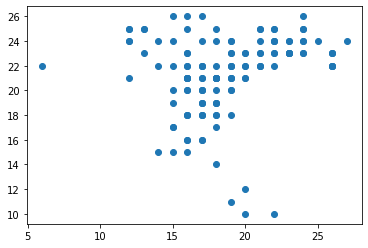

In [119]:
# Get array centers
RFcenters = np.zeros([NCv,2], dtype=np.int64) - 1
snrs = np.zeros(NCv)
for cc in range(NCv):
    k = glms[cc].get_weights()
    # pfilt = np.sum(np.std(k, axis=3),axis=0).squeeze() # for colorRFs
    pfilt = np.std(k, axis=2).squeeze()
    x,y, snrs[cc] = CU.RFstd_evaluate( pfilt )
    RFcenters[cc, :] = [x,y]

plt.plot(RFcenters[:, 0], RFcenters[:, 1],'o')
plt.show()

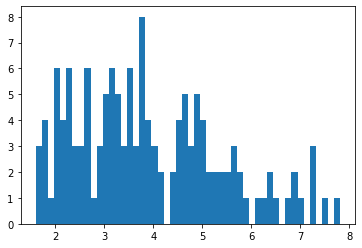

In [120]:
plt.hist(snrs,bins=50)
plt.show()

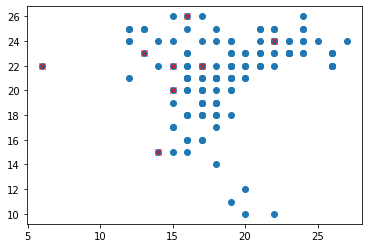

In [121]:
a = np.where(snrs < 2)[0]
plt.plot(RFcenters[:, 0], RFcenters[:, 1],'o')
plt.plot(RFcenters[a, 0], RFcenters[a, 1],'rx')
plt.show()

In [124]:
a = np.where((RFcenters[:,1] < 13.5) | (RFcenters[:,0] < 10))[0]
len(a), RFcenters[a,:]

(5,
 array([[ 6, 22],
        [20, 10],
        [19, 11],
        [22, 10],
        [20, 12]]))

In [125]:
RFcenters[a,0] = np.median(RFcenters[:,0])
RFcenters[a,1] = np.median(RFcenters[:,1])

In [126]:
# Generate full GLM model like full drift model
glm_layer = NDNLayer.layer_dict( 
    input_dims=[1, NXglm, NXglm, num_lags], num_filters=NCv, bias=False, NLtype='lin', initialize_center=True)
glm_layer['reg_vals'] = {'d2xt': XTreg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':100} 

stim_net =  FFnetwork.ffnet_dict( xstim_n='stim', layer_list=[glm_layer] )

drift_pars = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=NCv, bias=False, norm_type=0, NLtype='lin')
drift_pars['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0} } 

drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list=[drift_pars] )

comb_layer = ChannelLayer.layer_dict( num_filters=NCv, NLtype='softplus', bias=True )
comb_layer['weights_initializer'] = 'ones'

net_comb = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0,1],
    layer_list = [comb_layer], ffnet_type='add')

glm_all = NDN.NDN(  
            ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')

for cc in range(NCv):
    glm_all.networks[0].layers[0].weight.data[:, cc] = deepcopy(glms[cc].networks[0].layers[0].weight.data[:,0])
    glm_all.networks[1].layers[0].weight.data[:, cc] = deepcopy(glms[cc].networks[1].layers[0].weight.data[:,0])
    glm_all.networks[-1].layers[0].bias.data[cc] = deepcopy(glms[cc].networks[-1].layers[0].bias.data)

data.set_cells(valET)
LLsCHECK = glm_all.eval_models(data[data.val_inds], null_adjusted=False) 
print(np.mean(LLsNULL-LLsR[:,1]), np.mean(LLsNULL-LLsCHECK))

Output set to 136 cells
0.0059538334608078 0.0057649204836172216


In [127]:
LLsGLM = LLsNULL-LLsR[:,1]
dirname2 = dirname+'0808/'
sio.savemat(dirname2+'LLsGLM.mat', {
    'LLsNULL':LLsNULL[:,None], 'LLsGLM':LLsGLM[:, None], 'drift_terms': drift_terms, 'Dreg': Dreg,
    'RFcenters': RFcenters, 'top_corner': top_corner[:, None]})
drift_pop.save_model(alt_dirname=dirname2, filename='ETdriftmods_pop.pkl')
glm_all.save_model(alt_dirname=dirname2, filename='ETglms_pop.pkl')

  Saving model at /home/dbutts/ColorV1/CLRworkspace/0808/ETdriftmods_pop.pkl
  Saving model at /home/dbutts/ColorV1/CLRworkspace/0808/ETglms_pop.pkl
